<a href="https://colab.research.google.com/github/JFrankVC/tog/blob/main/modis_AOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount the Google Drive
# Allow access - check steps and methods in: https://neptune.ai/blog/google-colab-dealing-with-files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # if Colab root directory is shown, go to /content folder

Mounted at /content/drive


In [2]:
# How to install permanently non-preinstalled libraries
!pip install earthpy && touch /root/.ipython/profile_default/startup/00-first.py && echo "import earthpy" >> /root/.ipython/profile_default/startup/00-first.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 67.9 MB/s eta 0:00:00


In [3]:
!pip install pyhdf && touch /root/.ipython/profile_default/startup/00-first.py && echo "import pyhdf" >> /root/.ipython/profile_default/startup/00-first.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.4/771.4 kB 9.9 MB/s eta 0:00:00


In [4]:
# Import packages
import os
import warnings

import matplotlib.pyplot as plt
import numpy.ma as ma
import xarray as xr
from shapely.geometry import mapping, box
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import pandas as pd
import pyhdf

from osgeo import gdal
xr.set_options(display_style='html')

In [5]:
# Check current working directory corresponds to Google Drive
retval = os.getcwd()
print(f"Current working directory {retval}")

# Change the directory - Google Drive -> folder from project "MODIS_Mexico_ThirdOrderPP"
path = "/content/drive/MyDrive/Colab_Notebooks/Datasets/MODIS_Proyecto_PAD/LAADS/Optical_Depth_Land_and_Ocean/2021/"
os.chdir(path)

# Check current working directory corresponds to Google Drive
retval = os.getcwd()
print(f"Current working directory {retval}")

Current working directory /content
Current working directory /content/drive/MyDrive/Colab_Notebooks/Datasets/MODIS_Proyecto_PAD/LAADS/Optical_Depth_Land_and_Ocean/2021


In [6]:
# Set path to Dataset folder
folder_path = "/content/drive/MyDrive/Colab_Notebooks/Datasets/MODIS_Proyecto_PAD/LAADS/Optical_Depth_Land_and_Ocean/2021/"

In [7]:
# List all datatsets (HDF) in current folder
!ls

MOD04_3K.A2021001.mosaic.061.2023302034720.psmcgscs_000502040107.Optical_Depth_Land_And_Ocean.hdf
MOD04_3K.A2021002.mosaic.061.2023302034810.psmcgscs_000502040107.Optical_Depth_Land_And_Ocean.hdf
MOD04_3K.A2021003.mosaic.061.2023302034601.psmcgscs_000502040107.Optical_Depth_Land_And_Ocean.hdf
MOD04_3K.A2021004.mosaic.061.2023302034507.psmcgscs_000502040107.Optical_Depth_Land_And_Ocean.hdf
MOD04_3K.A2021005.mosaic.061.2023302034738.psmcgscs_000502040107.Optical_Depth_Land_And_Ocean.hdf
MOD04_3K.A2021006.mosaic.061.2023302034653.psmcgscs_000502040107.Optical_Depth_Land_And_Ocean.hdf
MOD04_3K.A2021007.mosaic.061.2023302035107.psmcgscs_000502040107.Optical_Depth_Land_And_Ocean.hdf
MOD04_3K.A2021008.mosaic.061.2023302034840.psmcgscs_000502040107.Optical_Depth_Land_And_Ocean.hdf
MOD04_3K.A2021009.mosaic.061.2023302035031.psmcgscs_000502040107.Optical_Depth_Land_And_Ocean.hdf
MOD04_3K.A2021010.mosaic.061.2023302034835.psmcgscs_000502040107.Optical_Depth_Land_And_Ocean.hdf
MOD04_3K.A2021011.mo

In [8]:
# Import package pyhdf for reading HDF files (method used in local code)
from pyhdf.SD import SD, SDC
import numpy as np

In [14]:
# Read all datasets from folder
parent_path = folder_path
files = os.listdir(parent_path)
NUM_DATASETS = len(files)
if any(".txt" in s for s in files):     # Check how many files are not HDF dataframes
    matching = [s for s in files if ".txt" in s]
    n_readmes = len(matching)
    NUM_DATASETS = NUM_DATASETS - n_readmes
    n_readmes = None
    matching = None
print(f"Files in folder: {files}")
print(f"Num files in folder: {NUM_DATASETS}")

Files in folder: ['MOD04_3K.A2021001.mosaic.061.2023302034720.psmcgscs_000502040107.Optical_Depth_Land_And_Ocean.hdf', 'MOD04_3K.A2021002.mosaic.061.2023302034810.psmcgscs_000502040107.Optical_Depth_Land_And_Ocean.hdf', 'MOD04_3K.A2021003.mosaic.061.2023302034601.psmcgscs_000502040107.Optical_Depth_Land_And_Ocean.hdf', 'MOD04_3K.A2021004.mosaic.061.2023302034507.psmcgscs_000502040107.Optical_Depth_Land_And_Ocean.hdf', 'MOD04_3K.A2021005.mosaic.061.2023302034738.psmcgscs_000502040107.Optical_Depth_Land_And_Ocean.hdf', 'MOD04_3K.A2021006.mosaic.061.2023302034653.psmcgscs_000502040107.Optical_Depth_Land_And_Ocean.hdf', 'MOD04_3K.A2021007.mosaic.061.2023302035107.psmcgscs_000502040107.Optical_Depth_Land_And_Ocean.hdf', 'MOD04_3K.A2021008.mosaic.061.2023302034840.psmcgscs_000502040107.Optical_Depth_Land_And_Ocean.hdf', 'MOD04_3K.A2021009.mosaic.061.2023302035031.psmcgscs_000502040107.Optical_Depth_Land_And_Ocean.hdf', 'MOD04_3K.A2021010.mosaic.061.2023302034835.psmcgscs_000502040107.Optical

In [19]:
ds_aod_twelve_months = []

for i in range(NUM_DATASETS):
    #print(i)
    path = parent_path + files[i]
    #print(f"File path i={i}: {path}")

    if (".hdf" in path):    # Ignore README files
        # Read file
        file = SD(path, SDC.READ,)

        #print(f"File Info: {file.info()}\n")
        #print(f"File Datasets: {file.datasets()}\n")

        # Extract AOD Land Ocean into a pyHDF Dataset
        DATAFIELD_NAME='Optical_Depth_Land_And_Ocean'
        ds_i = file.select(DATAFIELD_NAME)

        # Get array values (pixels)
        arr_i = ds_i[:, :]

        # Use _FillValue (-9999.0) and set it to NaN for better visualization
        arr_i[arr_i == int(-9999)] = 0

        ds_aod_twelve_months.append(arr_i)

In [21]:
NUM_DATASETS = len(ds_aod_twelve_months)
print(f"Num datasets = {NUM_DATASETS}")
print(ds_aod_twelve_months[0].shape)
print(type(ds_aod_twelve_months[0]))

Num datasets = 363
(740, 1403)
<class 'numpy.ndarray'>


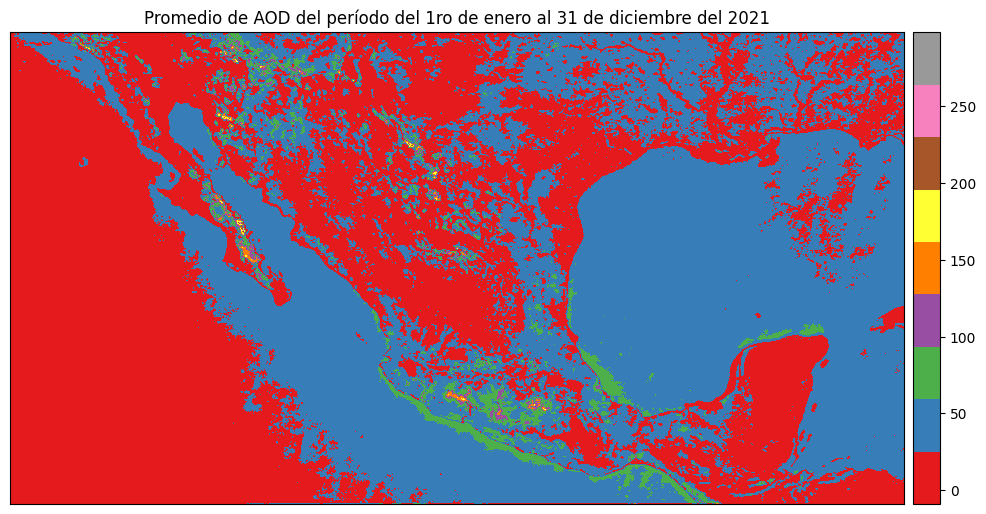

<Axes: title={'center': 'Promedio de AOD del período del 1ro de enero al 31 de diciembre del 2021'}>

In [23]:
# Get a copy of dataset 1 to store de mean
ds_mean_year_2021 = np.array(ds_aod_twelve_months[0])

# Boundaries for shape of arrays considering 0-based index
im_shape = ds_aod_twelve_months[0].shape
shape_x = im_shape[0] - 1   # This is dimension Y in array as seen in Panoply
shape_y = im_shape[1] - 1   # This is dimension X in array as seen in Panoply

# Get mean value for each pixel not considering NaN values
for i in range(shape_x):
    for j in range(shape_y):
        pixel_vector = []
        for dataset_number in range(NUM_DATASETS):
            pixel_vector.append(ds_aod_twelve_months[dataset_number][i][j])
            # print(f'Dataset Number: {dataset_number + 1}, X: {i}, Y: {j}')
        pixel_mean = np.nanmean(pixel_vector)   # using method nanmean so NaN values are not considered
        ds_mean_year_2021[i][j] = pixel_mean

# Plot band one of the data
ep.plot_bands(ds_mean_year_2021, cmap="Set1", title="Promedio de AOD del período del 1ro de enero al 31 de diciembre del 2021")

In [25]:
# Use scaling factor
SCALING = 0.0010000000474974513
ds_mean_year_2021 = ds_mean_year_2021*SCALING

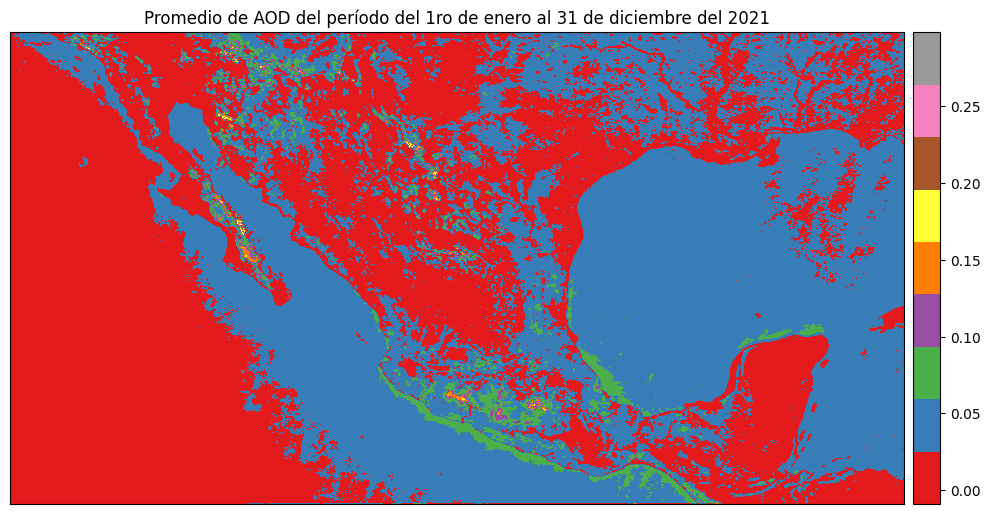

In [28]:
# Plot scaled data
im = ep.plot_bands(ds_mean_year_2021, cmap="Set1", title="Promedio de AOD del período del 1ro de enero al 31 de diciembre del 2021")